In [1]:
import os
import glob
import datetime
import numpy as np
import pandas as pd
import xarray as xr

from osgeo import gdal
#from gistool import rasterize
import pyhdf
from pyhdf.SD import SD
import geopandas as gpd

from scipy import stats
from scipy import integrate
from numpy import exp
import math
from pymannkendall import original_test as mk

import matplotlib as mpl
import matplotlib.pyplot as plt
## set the line width of the hatch
mpl.rcParams['hatch.linewidth'] = 0.5
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter,LatitudeFormatter
import matplotlib.ticker as mticker

## to monthly dataset

In [2]:
et0 =xr.open_dataset('/portal1/dell/li-b/MODIS1/et_qc_regrid0.nc')
et1 =xr.open_dataset('/portal1/dell/li-b/MODIS1/et_qc_regrid1.nc')
et2 =xr.open_dataset('/portal1/dell/li-b/MODIS1/et_qc_regrid2.nc')
et3 =xr.open_dataset('/portal1/dell/li-b/MODIS1/et_qc_regrid3.nc')
et4 =xr.open_dataset('/portal1/dell/li-b/MODIS1/et_qc_regrid4.nc')
et5 =xr.open_dataset('/portal1/dell/li-b/MODIS1/et_qc_regrid5.nc')


ds0 = xr.concat([et0,et1,et2,et3,et4,et5],dim='time')
ds0

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:  (time: 943, lat: 190, lon: 231)
Coordinates:
  * time     (time) object 2002-07-04 00:00:00 ... 2022-12-27 00:00:00
  * lat      (lat) float64 33.98 33.93 33.88 33.83 ... 24.68 24.63 24.58 24.53
  * lon      (lon) float64 110.5 110.6 110.6 110.7 ... 121.9 121.9 122.0 122.0
Data variables:
    vari     (time, lat, lon) float64 24.1 32.29 17.7 31.63 ... 0.0 0.0 0.0 nan

In [4]:
ds0.to_netcdf('/portal1/dell/li-b/MODIS1/et_qc_0.05.nc')

In [2]:
ds0 = xr.open_dataset('/portal1/dell/li-b/MODIS1/et_qc_0.05.nc')

# exclude taiwan(120.5,122)(24.5,25.5)   (100,115)(85,95)
arr = ds0['vari'].values
lats = ds0.lat.values
lons = ds0.lon.values

for i in range(0,len(lats)):
    for j in range(0,len(lons)):
        if i>=169 and j>=200:
            arr[:,i,j] = np.nan
        else:
            continue

ds00 = xr.Dataset({'vari': (['time','lat','lon'], arr)},
                      coords={'time': (['time'], ds0.time.values), 
                              'lat': (['lat'], ds0.lat.values),
                      'lon': (['lon'], ds0.lon.values),})

ds000 = ds00['vari'].resample(time='D').pad().to_dataset()
ds1 = ds000.resample(time='M').mean(skipna=True)
ds1

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


<xarray.Dataset>
Dimensions:  (lat: 190, lon: 231, time: 246)
Coordinates:
  * lat      (lat) float64 33.98 33.93 33.88 33.83 ... 24.68 24.63 24.58 24.53
  * lon      (lon) float64 110.5 110.6 110.6 110.7 ... 121.9 121.9 122.0 122.0
  * time     (time) object 2002-07-31 00:00:00 ... 2022-12-31 00:00:00
Data variables:
    vari     (time, lat, lon) float64 15.43 18.17 15.97 21.74 ... nan nan nan

In [ ]:
ds1.to_netcdf('/portal1/dell/li-b/multiregression/et1.nc')

## firstly all region

In [5]:
# area = ds1['vari'].mean(dim=['lat','lon'],skipna=True).values/8*30 ### 8d composite of ET HERE is average of 8 days
# df_m = pd.DataFrame({'time':ds1.time.values,'vari':area})
# df_m.set_index('time',inplace=True)

# times = pd.date_range('2002-07-31', '2022-12-31', freq='M')
# df = pd.DataFrame({'time':times,'vari':df_m['vari'].values})
# df.set_index('time',inplace=True)

# df_7 = df['vari'].loc[df.index.month==7].values
# df_8 = df['vari'].loc[df.index.month==8].values
# df_9 = df['vari'].loc[df.index.month==9].values
# times = pd.date_range('2002','2023',freq='Y')

# df1 = pd.DataFrame({'time':times,'jul':df_7,'agu':df_8,'sep':df_9})
# df1['jas'] = (df1['jul'] + df1['agu'] + df1['sep'])
# df1.set_index('time',inplace=True)

# times = pd.date_range('2002-07-31', '2022-12-31', freq='M')
# df = pd.DataFrame({'time':times,'vari':df_m['vari'].values})
# df.set_index('time',inplace=True)

# df_7 = df['vari'].loc[df.index.month==7].values
# df_8 = df['vari'].loc[df.index.month==8].values
# df_9 = df['vari'].loc[df.index.month==9].values
# times = pd.date_range('2002','2023',freq='Y')

# df1 = pd.DataFrame({'time':times,'jul':df_7,'agu':df_8,'sep':df_9})
# df1['jas'] = (df1['jul'] + df1['agu'] + df1['sep'])
# df1.set_index('time',inplace=True)

# date = np.arange(2002,2023)
# results = {}

# for column in df1.columns:
#     v1 = df1[column].values
    
#     tr = mk(v1, alpha=0.05).trend
#     if tr=='increasing':
#         pvalue=1
#         slo = stats.linregress(date,v1).slope
#         interc = stats.linregress(date,v1).intercept
#         trend = slo*date + interc
#         df1[column+'_ano'] = df1[column].values - trend
#     elif tr=='decreasing':
#         pvalue=-1
#         slo = stats.linregress(date,v1).slope
#         interc = stats.linregress(date,v1).intercept
#         trend = slo*date + interc
#         df1[column+'_ano'] = df1[column].values - trend
#     elif tr=='no trend':
#         pvalue=np.nan
#         df1[column+'_ano'] = df1[column].values - df1[column].values.mean() 
    
#     results[column] = (slo, pvalue)
# results

# df = df1[['jul_ano','agu_ano','sep_ano','jas_ano']]
# df

,vari
time,
2002-07-31 00:00:00,113.179807
2002-08-31 00:00:00,113.972845
2002-09-30 00:00:00,81.701159
2002-10-31 00:00:00,47.848943
2002-11-30 00:00:00,33.011210
...,...
2022-08-31 00:00:00,114.238579
2022-09-30 00:00:00,82.760878
2022-10-31 00:00:00,51.455332


In [3]:
ds_m0 = ds1.sel(time=ds1['time.month'].isin([7]))
ds_m = ds_m0['vari'].values/8*30

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano7 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_m0.time.values), 
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})
##################################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([8]))
ds_m = ds_m0['vari'].values/8*30

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano8 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_m0.time.values), 
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})
##############################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([9]))
ds_m = ds_m0['vari'].values/8*30

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano9 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_m0.time.values), 
                              'lat': (['lat'], ds_m0.lat.values),
                      'lon': (['lon'], ds_m0.lon.values),})
########################################################################################################
ds_m0 = ds1.sel(time=ds1['time.month'].isin([7,8,9]))
ds_m1 = ds_m0.groupby('time.year').mean(dim='time',skipna=True)
ds_m = ds_m1['vari'].values/8*90

anos = np.zeros_like(ds_m)

for i in range(0,ds_m.shape[2]):
    for j in range(0,ds_m.shape[1]):
        v1 = ds_m[:,j,i]
        date = np.arange(2002,2023)
        
        non_nan_count = np.count_nonzero(~np.isnan(v1))
        if non_nan_count > 1:
            tr = mk(v1, alpha=0.05).trend
            if tr=='increasing':
                pvalue=1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='decreasing':
                pvalue=-1
                slo = stats.linregress(date,v1).slope
                interc = stats.linregress(date,v1).intercept
                trend = slo*date + interc
                anos[:,j,i] = v1 - trend
            elif tr=='no trend':
                pvalue=np.nan
                anos[:,j,i] = v1 - v1.mean()
        else:
            anos[:,j,i] = v1 - v1.mean()
            
ds_ano789 = xr.Dataset({'vari': (['time','lat','lon'], anos)},
                      coords={'time': (['time'], ds_ano7.time.values), 
                              'lat': (['lat'], ds_m1.lat.values),
                      'lon': (['lon'], ds_m1.lon.values),})

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [20]:
c7 = ds_ano7['vari'].mean(dim=['lat','lon'],skipna=True).values
c8 = ds_ano8['vari'].mean(dim=['lat','lon'],skipna=True).values
c9 = ds_ano9['vari'].mean(dim=['lat','lon'],skipna=True).values
c789 = ds_ano789['vari'].mean(dim=['lat','lon'],skipna=True).values
times = pd.date_range('2002','2023',freq='Y')
df1 = pd.DataFrame({'time':times,'jul_ano':c7,'agu_ano':c8,'sep_ano':c9,'jas_ano':c789})
df1

,time,jul_ano,agu_ano,sep_ano,jas_ano
0,2002-12-31,-0.875155,0.150728,-6.056470,-5.569184
1,2003-12-31,2.071075,0.959599,-0.831259,3.197519
2,2004-12-31,-3.142342,-2.909063,-8.852032,-14.179759
3,2005-12-31,-2.022017,-3.013563,7.071316,2.919790
4,2006-12-31,0.758288,0.843065,-9.221579,-6.979846
5,2007-12-31,0.811726,1.540050,-1.264647,1.634872
6,2008-12-31,-3.051285,-4.792767,4.868815,-2.658601
7,2009-12-31,-0.160712,1.455604,2.105855,3.774555
8,2010-12-31,-6.071474,1.639416,12.305767,8.192101
9,2011-12-31,-2.816210,-2.793639,0.294733,-5.007018


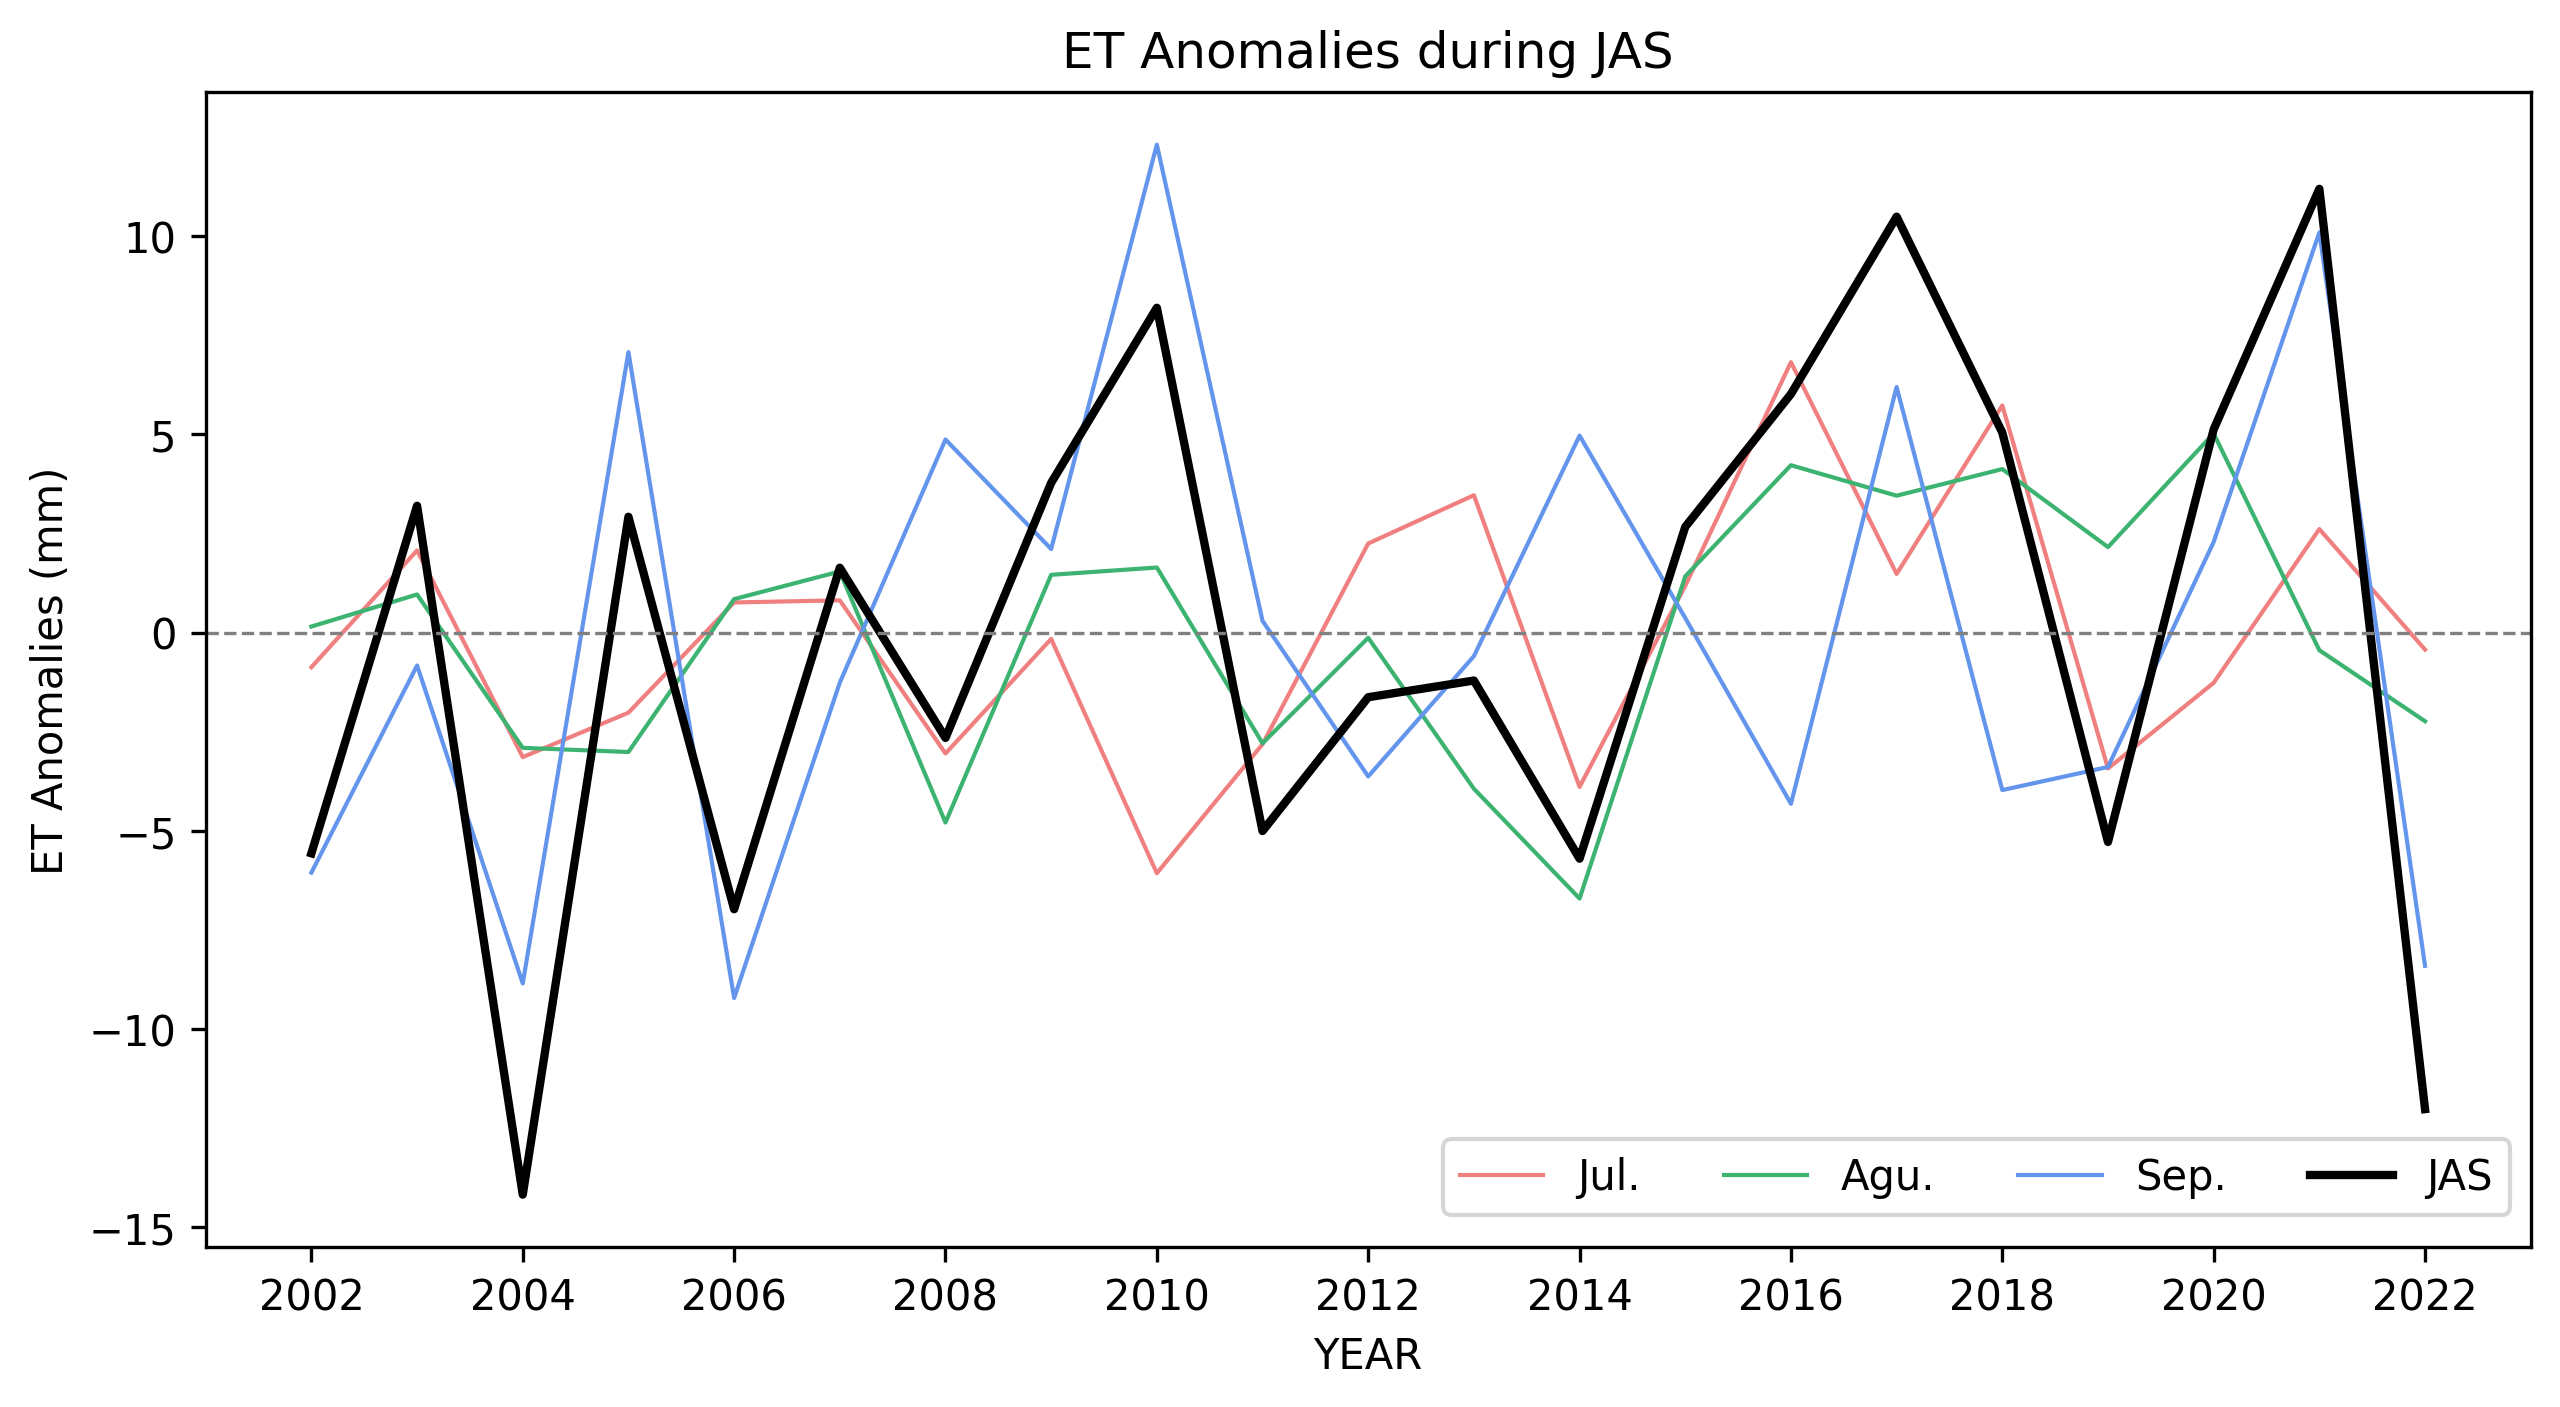

In [21]:
date = np.arange(2002,2023)
v1 = df1['jul_ano']
v2 = df1['agu_ano']
v3 = df1['sep_ano']
v4 = df1['jas_ano']

fig, ax = plt.subplots(1,1,dpi=300,figsize=(10,5))


ax.plot(date, v1,color='lightcoral',lw=1, ls='-', label='Jul.')
ax.plot(date, v2,color='mediumseagreen',lw=1, ls='-', label='Agu.')
ax.plot(date, v3,color='cornflowerblue',lw=1, ls='-', label='Sep.')
ax.plot(date, v4,color='black',lw=2, ls='-', label='JAS')

ax.set_ylabel('ET Anomalies (mm)')
#ax1.set_ylabel('PRR (%)')
ax.set_xlabel('YEAR')
custom_ticks = np.arange(2002, 2023, step=2)  # Define the tick locations
custom_tick_labels = [str(year) for year in custom_ticks]  # Define the tick labels

ax.set_xticks(custom_ticks)
ax.set_xticklabels(custom_tick_labels)

ax.axhline(y=0, color='gray', linestyle='--',lw=0.8)
    
#figname = filename.replace('.txt','')
ax.set_title('ET Anomalies during JAS')
ax.set_xlim(date[0]-1, date[-1]+1)
fig.legend(loc="lower right", bbox_to_anchor=(1, 0.01), bbox_transform=ax.transAxes, ncol = 5)

#plt.savefig('D:/rice/figs/middleyield.png')                         
plt.show()

In [12]:
d7_0 = ds_ano7['vari'].values
box7 = d7_0[~np.isnan(d7_0)].ravel()

d8_0 = ds_ano8['vari'].values
box8 = d8_0[~np.isnan(d8_0)].ravel()

d9_0 = ds_ano9['vari'].values
box9 = d9_0[~np.isnan(d9_0)].ravel()

d789_0 = ds_ano789['vari'].values
box789 = d789_0[~np.isnan(d789_0)].ravel()

box = [box7,box8,box9,box789]
for i in box:
    lo = np.nanpercentile(i,q=25)
    up = np.nanpercentile(i,q=75)
    upbo = up+1.5*(up-lo)
    lobo = lo-1.5*(up-lo)
    maxmum = i.max()
    minmum = i.min()
    print(upbo, lobo, maxmum, minmum)

29.447087748771946 -29.759947167726484 94.77523679961652 -92.18495077946221
33.08991470208994 -36.92076308357434 67.73077681625263 -88.78520837098193
32.210737941214 -49.418319116382335 65.30503539443335 -66.89732555916271
69.45094390743697 -92.77546639293564 133.15453779228358 -195.3062327394157


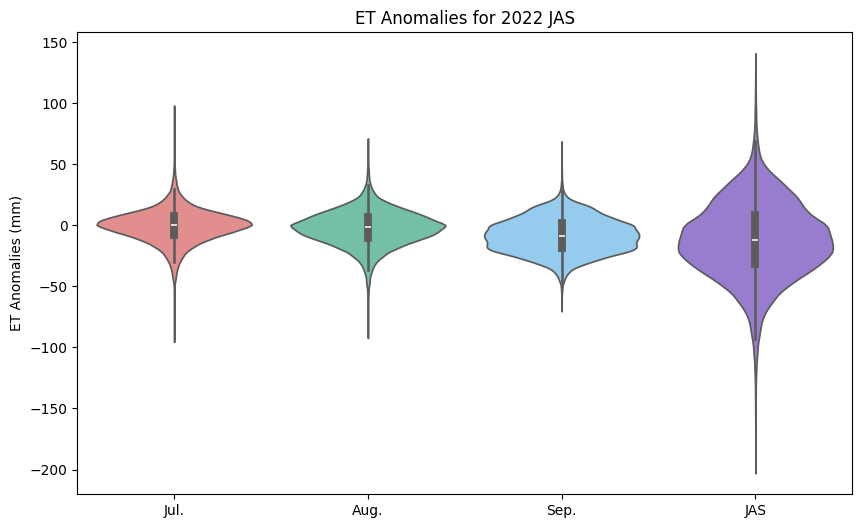

In [13]:
import seaborn as sns

data_to_plot = [box7, box8, box9, box789]
custom_palette = ["lightcoral", "mediumaquamarine", "lightskyblue", "mediumpurple"]
# Create a violin plot for all datasets in one figure
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_to_plot, palette=custom_palette, inner='box')

# Customize the plot as needed
plt.title('ET Anomalies for 2022 JAS')
# plt.xlabel('Datasets')
plt.ylabel('ET Anomalies (mm)')
custom_labels = ['Jul.', 'Aug.', 'Sep.','JAS']
plt.xticks(range(len(custom_labels)), custom_labels)
# Show the plot
plt.show()

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Jul. ET Anomalies')

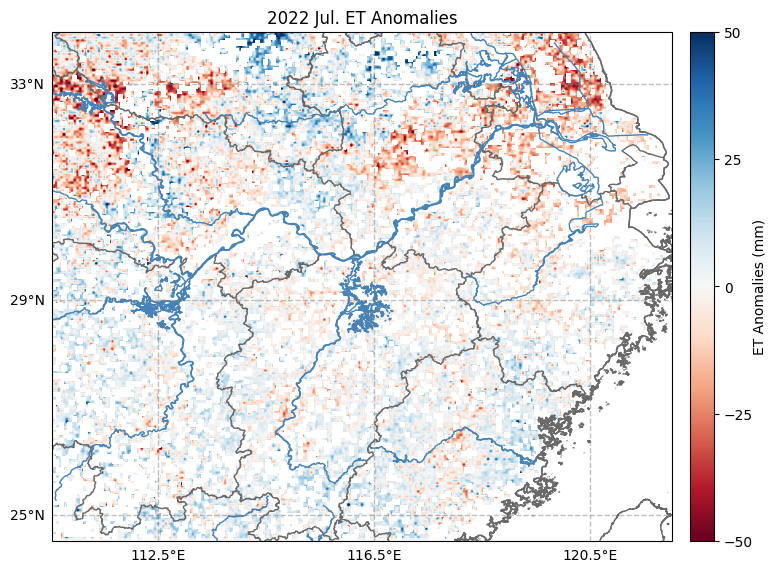

In [14]:
data = ds_ano7['vari'].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=50
vmin=-50
cmap = plt.get_cmap('RdBu')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('ET Anomalies (mm)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Jul. ET Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Agu. ET Anomalies')

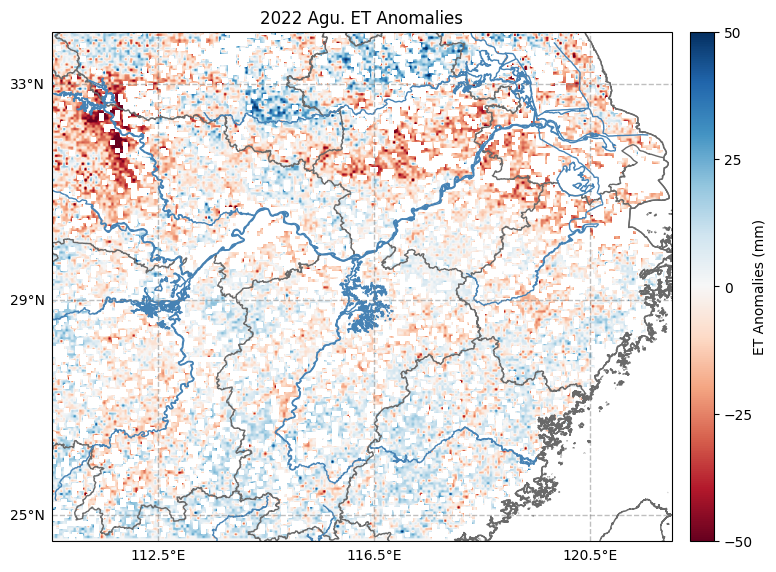

In [15]:
data = ds_ano8['vari'].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=50
vmin=-50
cmap = plt.get_cmap('RdBu')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('ET Anomalies (mm)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Agu. ET Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 Sep. ET Anomalies')

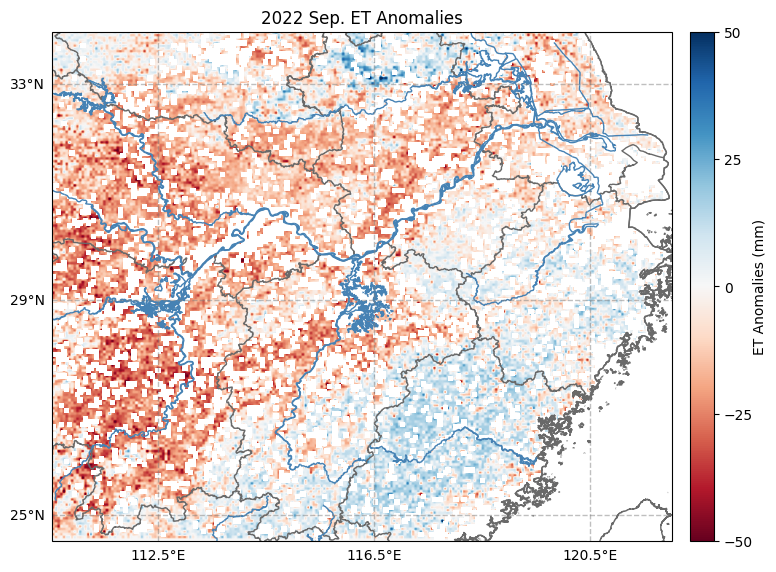

In [16]:
data = ds_ano9['vari'].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=50
vmin=-50
cmap = plt.get_cmap('RdBu')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('ET Anomalies (mm)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 Sep. ET Anomalies')

/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/li-b/.conda/envs/lbn/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


Text(0.5, 1.0, '2022 JAS ET Anomalies')

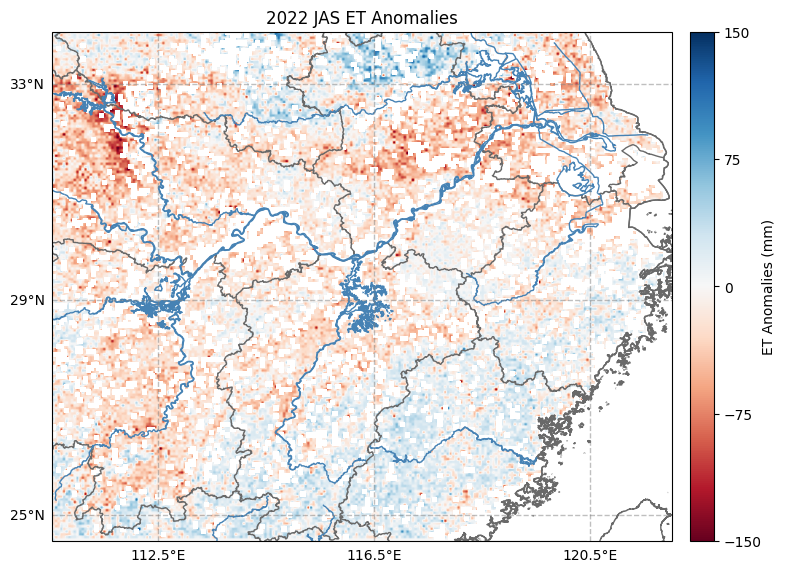

In [17]:
data = ds_ano789['vari'].values
gdf1 = gpd.read_file('/portal1/dell/li-b/meteo/bound.shp')
gdf2 = gpd.read_file('/portal1/dell/li-b/meteo/allrivers.shp')
latitude, longitude = ds_ano7.lat.values, ds_ano7.lon.values

vmax=150
vmin=-150
cmap = plt.get_cmap('RdBu')

projection = ccrs.PlateCarree()
# arr_flipped = np.flip(data, axis=0)
arr_flipped = data
fig, ax = plt.subplots(figsize=(8,10),subplot_kw={'projection': ccrs.PlateCarree()})
gdf1.plot(ax=ax, facecolor='none', edgecolor='dimgray', linewidth=1)
gdf2.plot(ax=ax, facecolor='none', edgecolor='steelblue', linewidth=1)
img = ax.imshow(arr_flipped, extent=[longitude.min(), longitude.max(), latitude.min(), latitude.max()],
                transform=projection,
                cmap=cmap,
                vmax=vmax,
                vmin=vmin)


ticks = list(np.linspace(vmin, vmax, 5))
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
pos = ax.get_position()
pad = 0.015*1.5
width = 0.015*2
clen = 0.6
cax = fig.add_axes([pos.xmax + pad, pos.ymin, width, (pos.ymax - pos.ymin)])
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, extend='neither', orientation='vertical')
cbar.ax.set_ylabel('ET Anomalies (mm)')
cbar.set_ticks(ticks)
# Adjust the distance between colorbar label and colorbar
labelpad = 0.001  # Adjust this value as needed
cbar.ax.yaxis.labelpad = labelpad

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([112.5,116.5,120.5])
gl.ylocator = mticker.FixedLocator([25,29,33])

ax.set_title('2022 JAS ET Anomalies')

## secondly for different veg. types

In [4]:
mask = xr.open_dataset('/portal1/dell/li-b/LC_IGBP_2022_epsg4326.tif')


x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']
qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a==1) | (qc_a == 2) | (qc_a == 4) | (qc_a == 5)
vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
array_1b = vari_b.ravel()
pv = stats.ttest_ind(array_1b[~np.isnan(array_1b)],0).pvalue
print('forest', np.nanmean(vari_b), pv)
ds_tree = xr.Dataset({'vari': (['lat','lon'], vari_b)},
                    coords={ 
                            'lat': (['lat'], ds_ano789.lat.values),
                            'lon': (['lon'], ds_ano789.lon.values),})


x = ds_ano789.dims['lon']
y = ds_ano789.dims['lat']
qc_a = mask['band_data'].sel(band=1).values
qc_b = np.zeros((y, x), dtype=bool)
qc_b = (qc_a == 12) | (qc_a == 14)
vari_a = ds_ano789['vari'][20,:,:].values
vari_b = np.zeros((y, x))
vari_b = np.where(qc_b, vari_a, np.nan)
pv = stats.ttest_ind(array_1b[~np.isnan(array_1b)],0).pvalue
print('crop', np.nanmean(vari_b), pv)
ds_crop = xr.Dataset({'vari': (['lat','lon'], vari_b)},
                    coords={ 
                            'lat': (['lat'], ds_ano789.lat.values),
                            'lon': (['lon'], ds_ano789.lon.values),})

forest 6.8777161240254285 0.803760348179961
crop -16.904975860815384 0.803760348179961


In [5]:
def exclude_sichuan(ds_full):
    arr = ds_full['vari'].values.copy()
    arr[:80,:51] = np.nan
    ds_ex = xr.Dataset({'vari': (['lat','lon'], arr)},
                      coords={ 
                                'lat': (['lat'], ds_full.lat.values),
                        'lon': (['lon'], ds_full.lon.values),})
    return ds_ex

ds_tree1 = exclude_sichuan(ds_tree)
ds_crop1 = exclude_sichuan(ds_crop)

In [6]:
import pyhdf
from pyhdf.SD import SD, SDC  

f = SD('/portal1/dell/li-b/MCD12C1.A2022001.061.2023244164746.hdf', SDC.READ)
# f.datasets()
newlat = np.linspace(89.975, -89.975, 3600) ## care about the order of lat and lon
newlon = np.linspace(-179.975, 179.975, 7200)

varis = f.select('Land_Cover_Type_1_Percent')[:,:,1]
ds_per1 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,2]
ds_per2 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,4]
ds_per4 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,5]
ds_per5 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,12]
ds_per12 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

varis = f.select('Land_Cover_Type_1_Percent')[:,:,14]
ds_per14 = xr.Dataset({'vari': (['lat','lon'], varis)},
                      coords={ 'lat': (['lat'], newlat),
                      'lon': (['lon'], newlon)})

arrl1 = ds_per1['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl2 = ds_per2['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl4 = ds_per4['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl5 = ds_per5['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl12 = ds_per12['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values
arrl14 = ds_per14['vari'].sel(lat=slice(33.975,24.525), lon=slice(110.525,122.025)).values

arr_p = arrl1 + arrl2 + arrl4 + arrl5
arr_p1 = arrl12 + arrl14


dem = xr.open_dataset('/portal1/dell/li-b/dem0.05.nc')
dems = dem['vari'].sel(time='2022-12-31').values

In [23]:
from scipy.stats import mode

x_1d_data = arr_p1.ravel()
y_1d_data = dems.ravel()
vari_b = ds_crop['vari'].values
z_1d_data = vari_b.ravel()

x_1d = arr_p[~np.isnan(arr_p1)].ravel()
y_1d = dems[~np.isnan(dems)].ravel()
z_1d = vari_b[~np.isnan(vari_b)].ravel()

bins = 100
x = np.linspace(np.round(x_1d.min(), decimals=1), np.round(x_1d.max(), decimals=1), bins)
y = np.linspace(np.round(y_1d.min(), decimals=1), np.round(1000, decimals=1), bins)
x_gap = (x.max()-x.min())/bins
y_gap = (y.max()-y.min())/bins
out_2d_arr = xr.DataArray(np.zeros((bins,bins)), [('dem',y),('cropland',x)])

for i in range(bins):
    for j in range(bins):
        index = np.argwhere(
            (x_1d_data >= x[j]-x_gap/2) & (x_1d_data < x[j]+x_gap/2) & (y_1d_data >= y[i]-y_gap/2) & (y_1d_data < y[i]+y_gap/2)
        ).ravel()
        sel = z_1d_data[index]
        if len(sel) == 0:
            out_2d_arr[i][j] = np.nan
        else:
            results = mode(sel)
            out_2d_arr[i][j] = results.mode

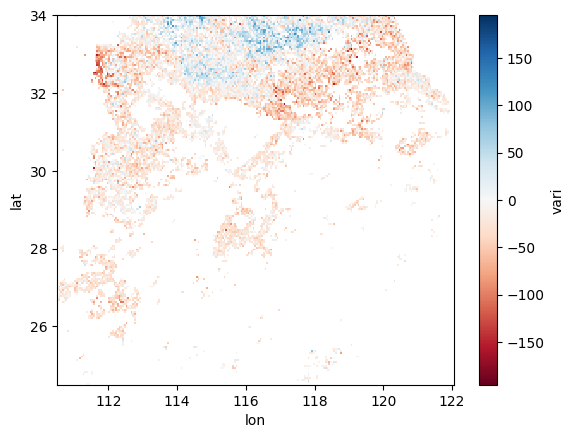

In [21]:
ds_crop['vari'].plot(cmap='RdBu')

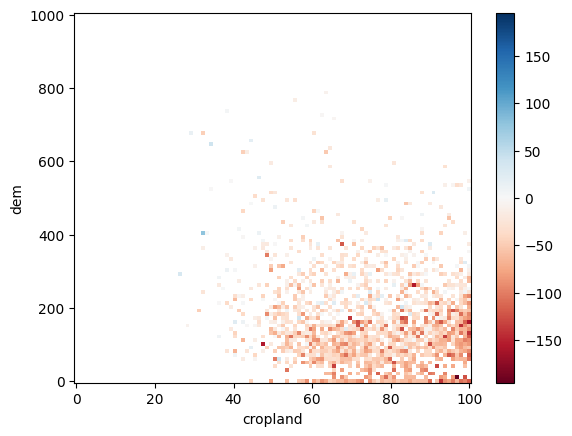

In [24]:
out_2d_arr.plot(cmap='RdBu')

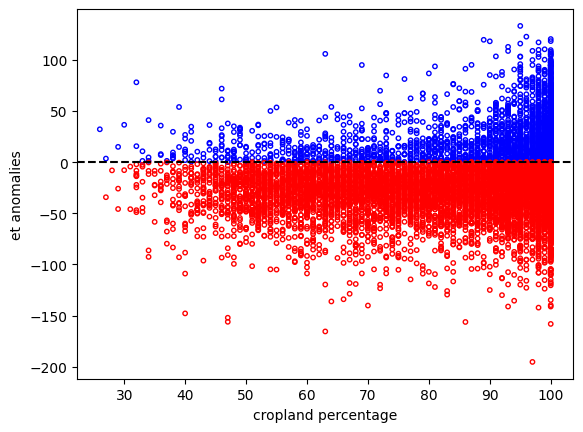

In [26]:
plt.scatter(x_1d_data[z_1d_data >= 0], z_1d_data[z_1d_data >= 0], s=10, facecolors='none', edgecolors='blue')
plt.scatter(x_1d_data[z_1d_data < 0], z_1d_data[z_1d_data < 0], s=10, facecolors='none', edgecolors='red')
plt.xlabel('cropland percentage')
plt.ylabel('et anomalies')
plt.axhline(y=0, color='black', linestyle='--')

In [21]:
from scipy.optimize import fsolve

# Define the function representing the fitted curve
def fitted_curve(x):
    return func(x, *popt)

# Define a function to find the intersection point with y=0
def find_intersection():
    # Use fsolve to find the root of the equation f(x) = 0
    x_intersection = fsolve(fitted_curve, 0)
    return x_intersection[0]

# Find the x-coordinate of the intersection point
x_intersection = find_intersection()
print("Intersection point (x-coordinate):", x_intersection)

Intersection point (x-coordinate): 30.119237922035268
